# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

/home/asklepiad/miniconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

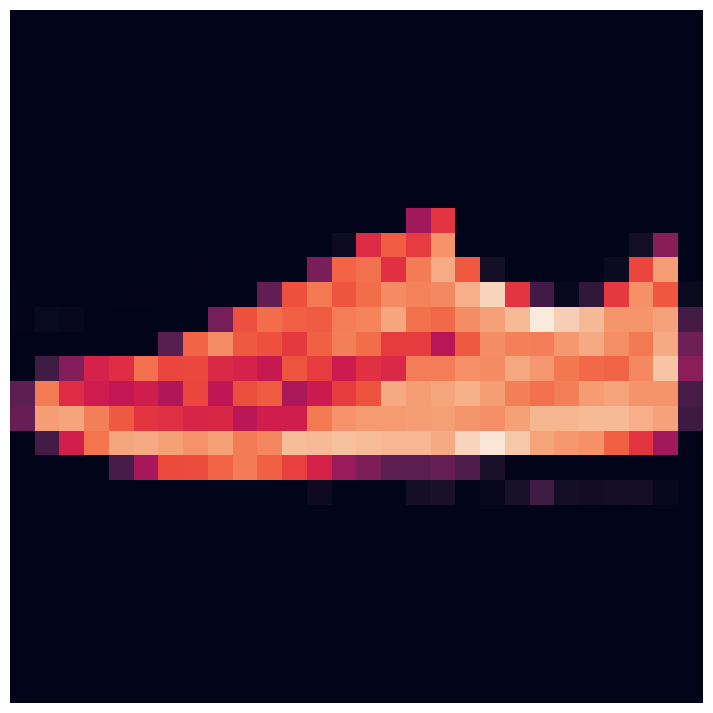

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

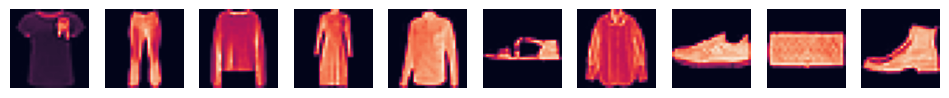

In [6]:
fig, axes = plt.subplots(ncols=10)
for classes in set(y):
    image = X[(np.where(y == classes)[0][0])].reshape(28, 28, 1)
    axes[int(classes)].imshow(image);
    axes[int(classes)].axis("off");

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

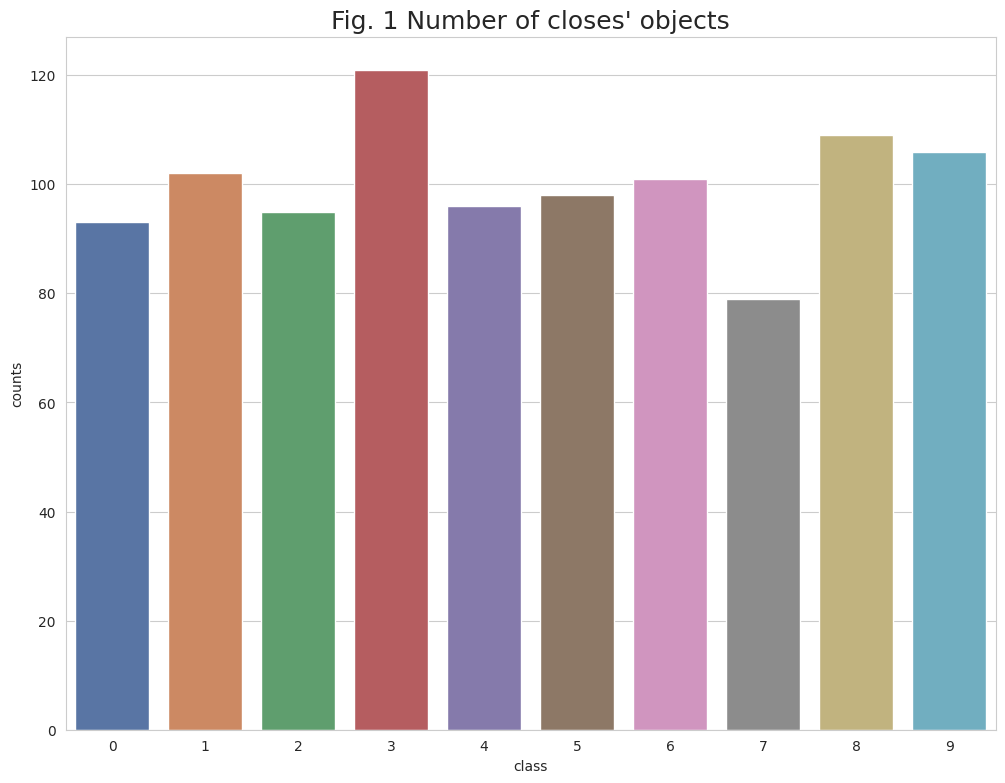

In [7]:
unique, counts = np.unique(y, return_counts=True)
class_freq = pd.DataFrame({
    "class": unique,
    "counts": counts,
})
axes = sns.barplot(class_freq, x="class", y="counts", palette=("deep")).set_title("Fig. 1 Number of closes' objects", fontsize=18)
axes;

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=111)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [10]:
# Оставляем данные с метками "0" и "1"
y10_train = np.where((y_train == "1") | (y_train == "0"))[0]
y10_test = np.where((y_test == "1") | (y_test == "0"))[0]

binary_train_X = X_train[y10_train]
binary_test_X = X_test[y10_test]
binary_train_y = y_train[y10_train]
binary_test_y = y_test[y10_test]

knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [11]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 0], np.sum(np.abs(binary_test_X[0] - binary_train_X[0])))

In [12]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 0], np.sum(np.abs(binary_test_X[0] - binary_train_X[0])))

In [13]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 0], np.sum(np.abs(binary_test_X[0] - binary_train_X[0])))

Проверим скорость работы реализованных методов

In [14]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

30.3 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.19 ms ± 81.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.4 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Резюме: одна петля хорошо, а две -- хуже. Одна петля лучше, чем ничего.

Реализуем метод для предсказания меток класса

Здесь и далее: для соответствия комментариям функций результаты бинарной классификации перекодированы в ```True``` и ```False```. Так как исходные данные представляли собой нули и единицы, и не было задачи строить функцию в общем виде, был создан специфический костыль. Был и альтернативный варинт -- оставить две категории строк, а при проверке склерновскими функциями метрик указывать ```pos_label="1"```. 

In [15]:
from sklearn.neighbors import (KNeighborsRegressor,
                               KNeighborsClassifier)

In [16]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X, n_loops=1)

In [17]:
# Проверил задним числом, так как смутила форма графика
knn_classifier2 = KNeighborsClassifier()
knn_classifier2.fit(binary_train_X, binary_train_y)
prediction2 = knn_classifier2.predict(binary_test_X)

In [24]:
(prediction == prediction2.astype("int8").astype("bool")).all()

True

Функция работает корректно -- во всяком случае, на этом датасете.

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [25]:
# TODO: binary_classification_metrics in metrics.py
binary_classification_metrics(prediction, binary_test_y)

(1.0, 1.0, 1.0, 1.0)

Вывод кортежа, возможно, не вполне эстетичен. Порядок метрик соотетствует таковому в описании функции.

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [32]:
binary_test_y = binary_test_y.astype("int64").astype("bool")
precision = precision_score(binary_test_y, prediction)
recall = recall_score(binary_test_y, prediction)
f1 = f1_score(binary_test_y, prediction)
accuracy = accuracy_score(binary_test_y, prediction)
print(" precision =", precision, "\n", "recall =", recall, "\n",
      "f1 =", f1, "\n", "accuracy =", accuracy)

 precision = 1.0 
 recall = 1.0 
 f1 = 1.0 
 accuracy = 1.0


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

В нашем случае в качестве метрики используем accuracy, так как ошибка в обоих направлениях относительно равнозначна, а количество данных двух классов примерно одинаково (Fig. 1).

P.S. Судя по коду ниже, авторы задачи также избрали accuracy, как приоритетный вариант.

In [33]:
# Немного киберboolинга данных -- чтобы все было единообразно
binary_train_y = binary_train_y.astype("int64").astype("bool")
binary_test_y = binary_test_y.astype("int64").astype("bool")

In [34]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []
    
    for ka in params:
        knn_classifier = KNNClassifier(k=ka)
        knn_classifier.fit(X_train, y_train)
        train_prediction = knn_classifier.predict(X_train)
        test_prediction = knn_classifier.predict(X_test)
        train_metrics.append(metric(y_train, train_prediction))
        test_metrics.append(metric(y_test, test_prediction))
        
    return(train_metrics, test_metrics)

In [46]:
params = [i for i in range(1,50)]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

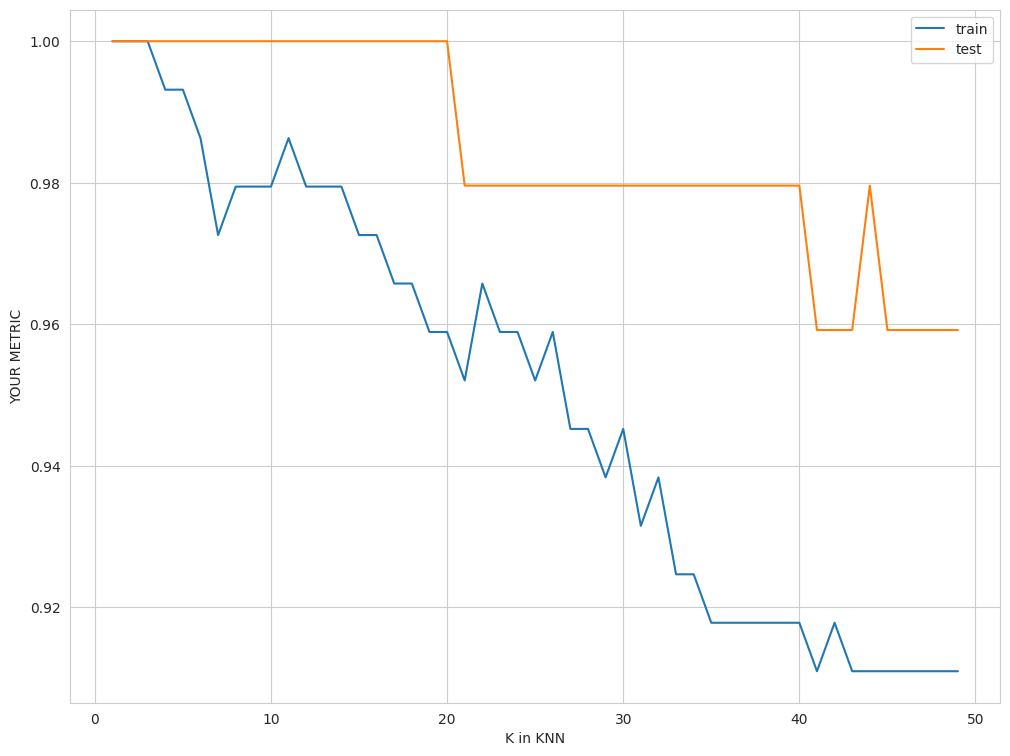

In [35]:
params = [i for i in range(1,50)]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, 
                                          binary_test_X, binary_test_y, 
                                          params, accuracy_score)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Сверим часы с официальным вариантом

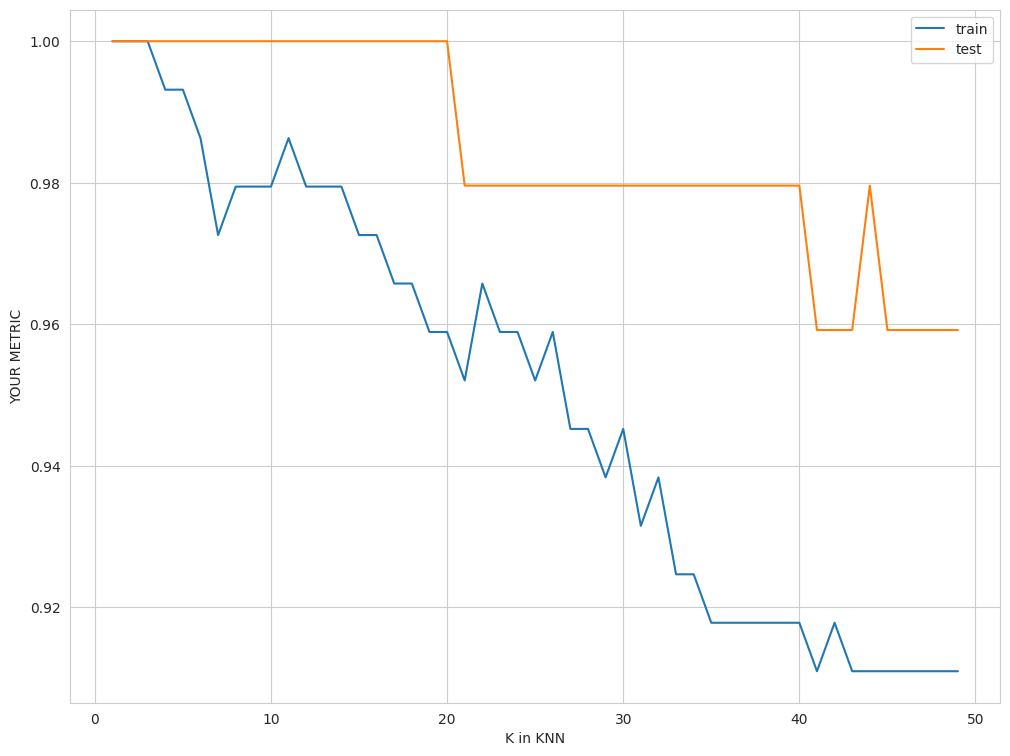

In [36]:
params = [i for i in range(1,50)]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, 
                                          binary_test_X, binary_test_y, 
                                          params, accuracy_score)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Странная форма графика не поменялась. Вероятнее, дело в данных, а не во мне.
P.S. Опрос сокурсников упрочил мою уверенность в вышеописанной догадке.

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

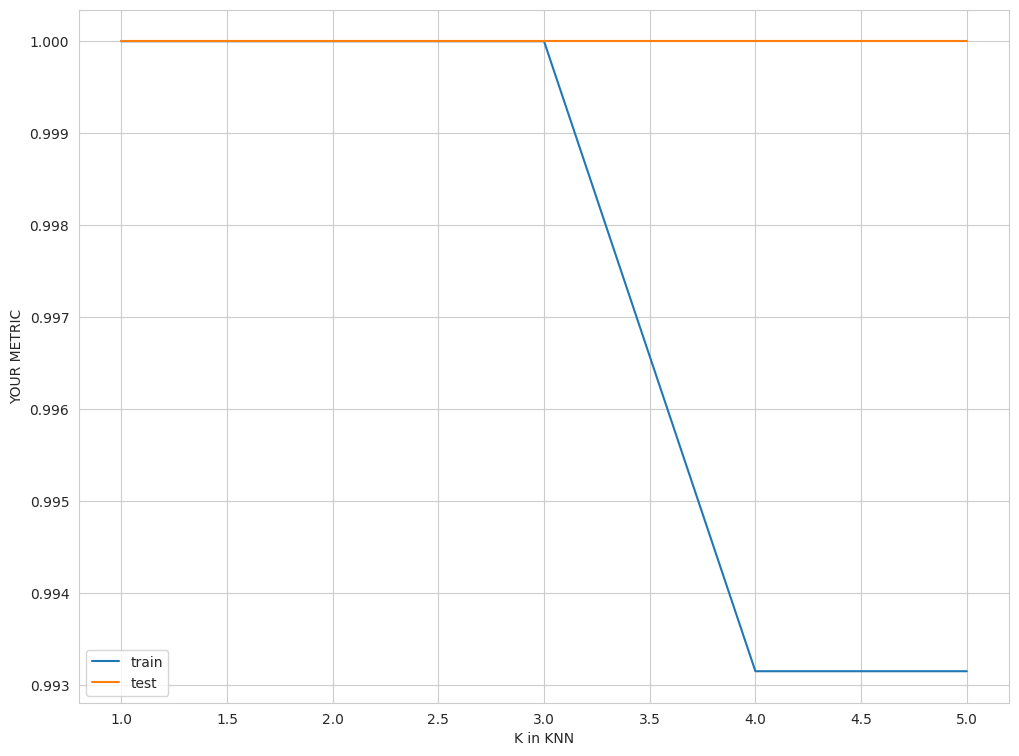

In [39]:
# Прогон для уточнения лучшего k
params = [i for i in range(1,6)]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, 
                                          binary_test_X, binary_test_y, 
                                          params, accuracy_score)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

При ```k = 3``` и обучающая, и контрольная выборка показывают абсолютный результат. Засим, примем  ```k = 3```.

In [45]:
# Создаем объект
knn_classifier = KNNClassifier(k=3)
# Обучаем модель
knn_classifier.fit(binary_train_X, binary_train_y)
# Предсказываем значения
prediction = knn_classifier.predict(binary_test_X, n_loops=1)
# Проверяем, насколько хорошо напредсказывали
print("Вы Нострадамус на", accuracy_score(prediction, binary_test_y)*100, "%")

Вы Нострадамус на 100.0 %


### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [46]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [47]:
# TODO: multiclass_accuracy in metrics.py
y_test = y_test.astype("int16")
multiclass_accuracy(predictions, y_test)

0.764

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [48]:
# Снова сделаем данные единообразными
y_train = y_train.astype("int64").astype("bool")
y_test = y_test.astype("int64").astype("bool")

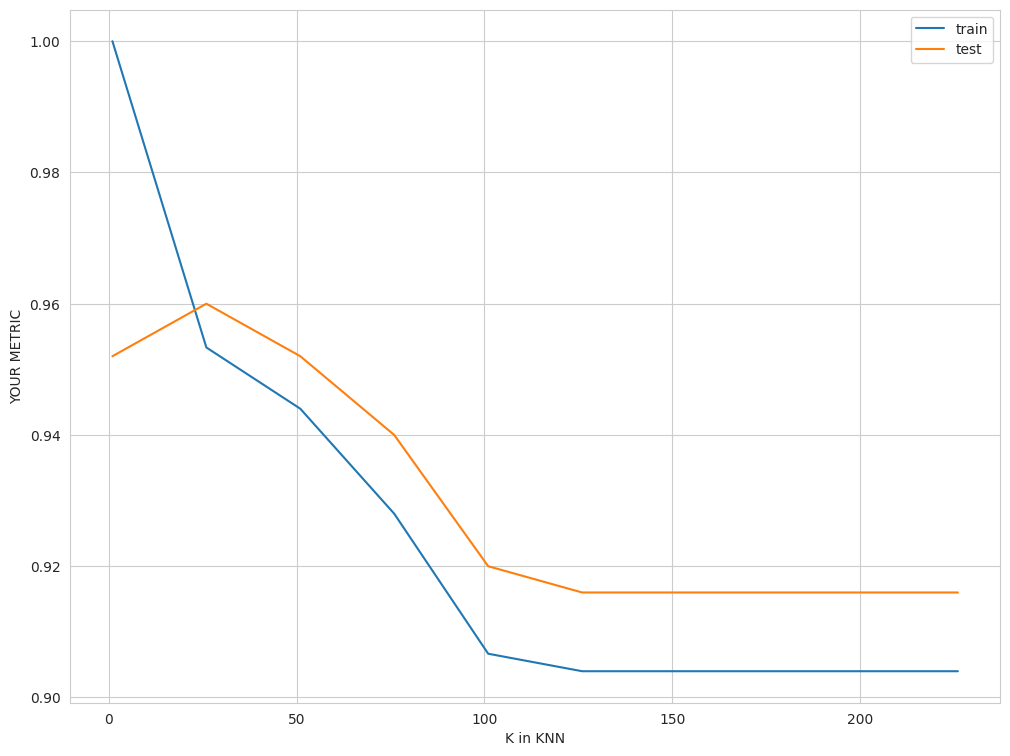

In [50]:
params = [i for i in range(1,251, 25)]
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, 
                                          params, multiclass_accuracy)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Пик где-то между ```k = 1``` ```k = 50```. Уточним.

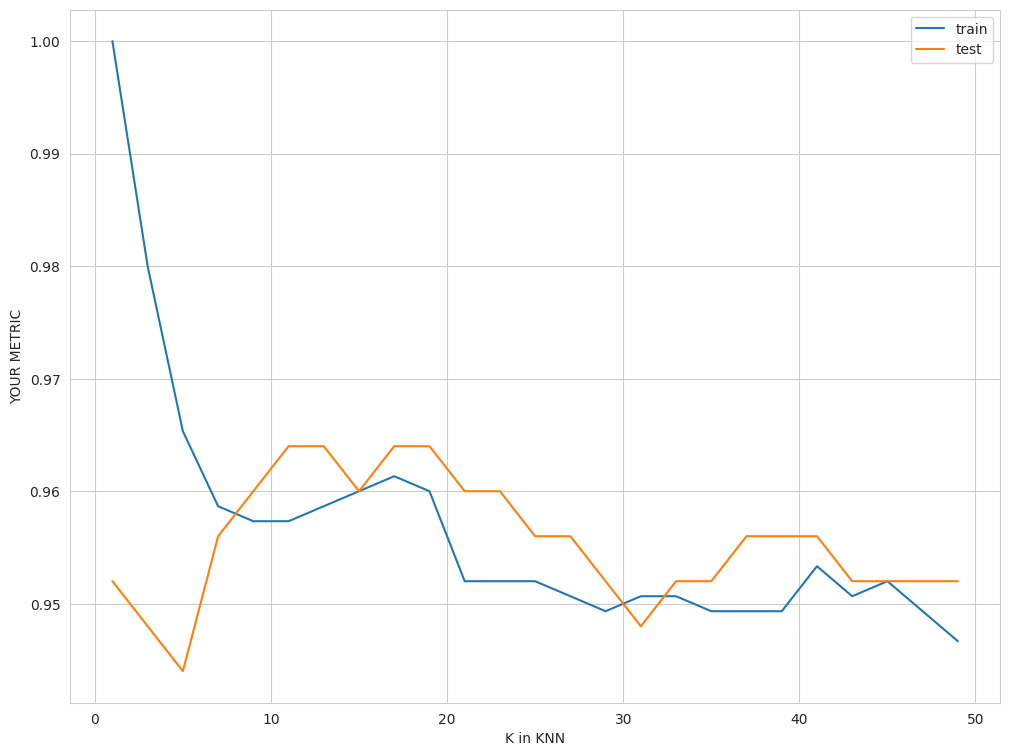

In [51]:
params = [i for i in range(1,51, 2)]
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, 
                                          params, multiclass_accuracy)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Решено избрать ```k = 19```.

In [52]:
# Создаем объект
knn_classifier = KNNClassifier(k=3)
# Обучаем модель
knn_classifier.fit(X_train, y_train)
# Предсказываем значения
prediction = knn_classifier.predict(X_test, n_loops=1)
# Проверяем, насколько хорошо напредсказывали
print("Вы Нострадамус на", multiclass_accuracy(prediction, y_test)*100, "%")

Вы Нострадамус на 94.8 %


## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [53]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [54]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [55]:
# Посмотрим на часть данных
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

Стандартизация не нужна, т.к. данные уже стандартизованы. Если бы это было иначе, стандартизация бы потребовалась, т.к. это позволит прийти к безразмерным единицам измерения и нивелировать различный уровень влияния колебания в данных. Пайплан со стандартизацией выполняется баллов ради.

In [26]:
# Разведочный анализ данных
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01


In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [29]:
y.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

Разобьем данные на ```train``` и ```test```.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=111)

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   LabelEncoder)
from sklearn.compose import ColumnTransformer

In [59]:
# Пайплайн. Все функции и аргументы реализованы внутри (стандартизация лишняя). Значение k выбрано полурандомно -- из примера на лекции. Так как брать один для регрессии как-то совсем не комильфо.
knn_pipeline = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(transformers=[
        ("scaler", StandardScaler(), ["age", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6"]),
        ("ohe", OneHotEncoder(sparse_output=False, drop="first"), ["sex"])
    ])),
    ("knn", KNeighborsRegressor(n_neighbors=8))
])

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [60]:
knn_pipeline.fit(X_train, y_train)
predicted = knn_pipeline.predict(X_test).round()
predicted

array([179., 107., 170., 143., 169., 202., 118., 100., 112.,  87., 123.,
       224., 204., 228., 190., 171., 171., 131., 215.,  88.,  99., 153.,
       133., 224.,  89., 103.,  72., 130., 191., 124., 159., 126., 178.,
       174., 149., 122.,  97., 173., 153., 129., 173., 288., 141., 127.,
       150.,  84., 185.,  99., 202., 157., 161., 209., 249., 108., 202.,
       104., 115., 178.,  89.,  94.,  79., 129., 189., 107., 266., 172.,
        80., 109., 258., 201., 176., 165., 107., 198., 173., 129.,  84.,
       101., 123., 142., 117., 122., 270., 106., 124.,  90., 209.,  97.,
       124., 263., 200.,  74., 221., 160., 266., 104.,  85.,  88., 108.,
       130., 178., 205., 104.,  96., 218., 114., 183.,  84., 151., 164.,
       111.])

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [62]:
# Делаем данные единообразными
y_prom = y_test.to_numpy()

In [61]:
# TODO: r_squared, mse, mae in metrics.py
from metrics import r_squared, mse, mae

In [63]:
r_squared(predicted, y_prom)

0.358620127445769

In [64]:
r2_score(y_prom, predicted)

0.358620127445769

In [65]:
mse(y_prom, predicted)

3214.5225225225226

In [66]:
mean_squared_error(y_prom, predicted)

3214.5225225225226

In [67]:
mae(y_prom, predicted)

45.31531531531532

In [68]:
mean_absolute_error(y_prom, predicted)

45.31531531531532

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

Я не придумал, как это сделать, т.к. в прошлой реализации в функцию был вшит кнн-классификатор, а здесь -- кнн-регрессор. Поэтому записал функцию в несколько другой ипостаси.

In [69]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []
    
    for ka in params:
        knn_pipeline = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(transformers=[
        ("scaler", StandardScaler(), ["age", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6"]),
        ("ohe", OneHotEncoder(sparse_output=False, drop="first"), ["sex"])
    ])),
    ("knn", KNeighborsRegressor(n_neighbors=ka))
])
        knn_pipeline.fit(X_train, y_train)
        train_prediction = knn_pipeline.predict(X_train).round()
        test_prediction = knn_pipeline.predict(X_test).round()
        train_metrics.append(metric(y_train, train_prediction))
        test_metrics.append(metric(y_test, test_prediction))

    return(train_metrics, test_metrics)

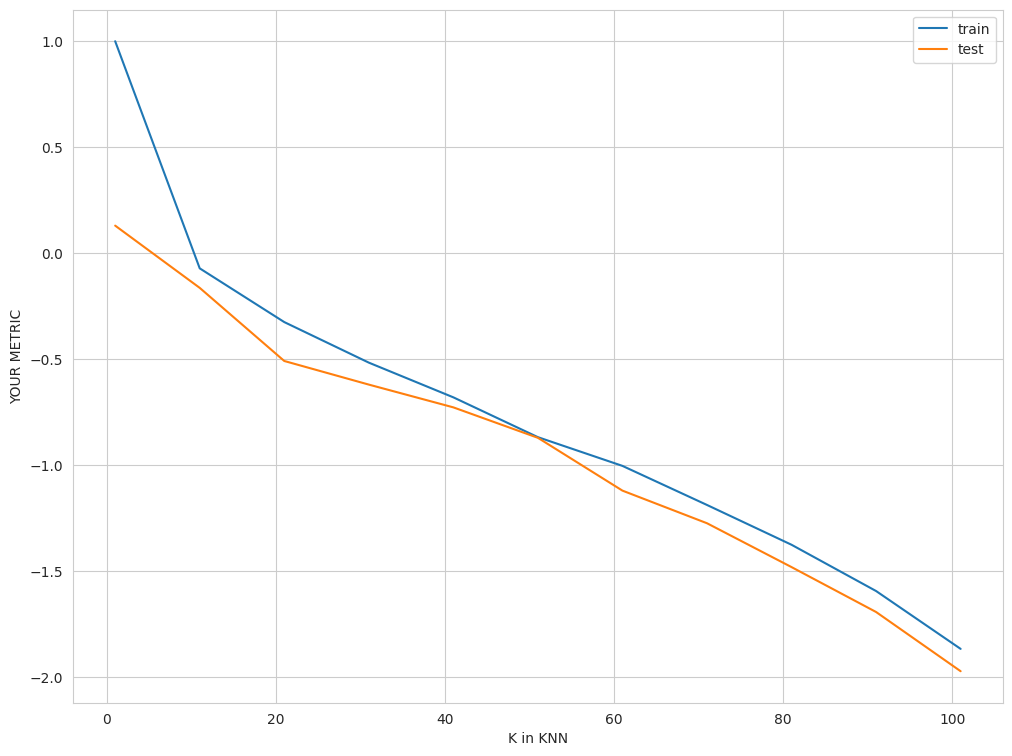

In [70]:
# R-квадрат
params = [i for i in range(1,111, 10)]
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, 
                                          params, r_squared)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

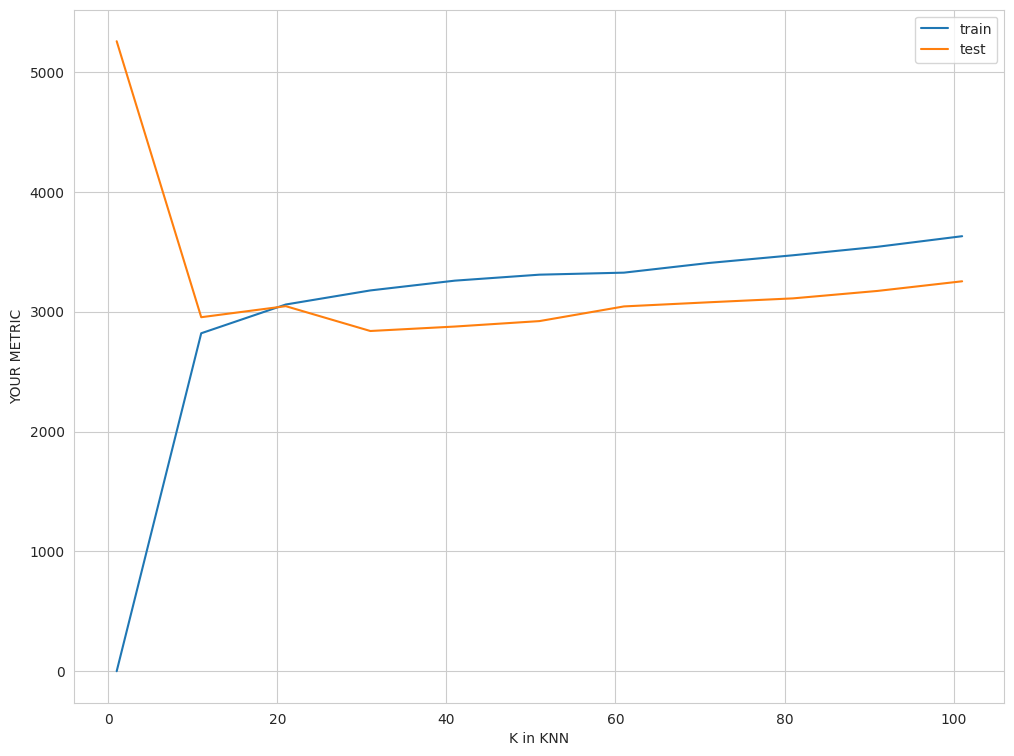

In [71]:
# MSE
params = [i for i in range(1,111, 10)]
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, 
                                          params, mse)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

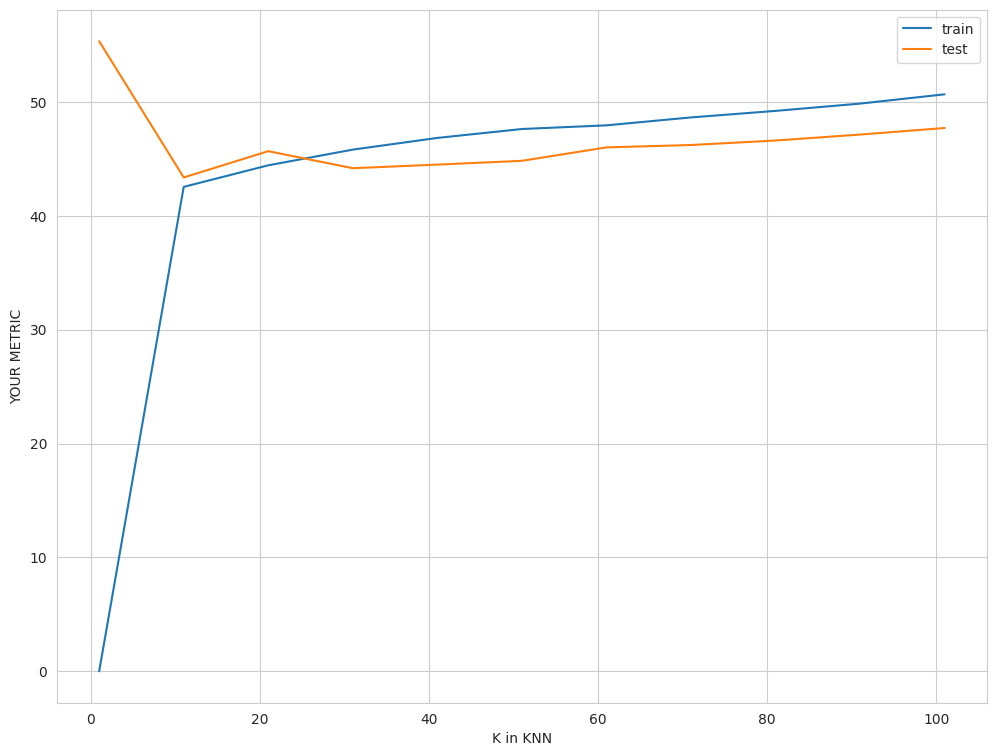

In [72]:
# MAE
params = [i for i in range(1,111, 10)]
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, 
                                          params, mae)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Сопоставление графиков позволяет высказать предположение о том, что стоит взять k между 1 и 31. Повторим.

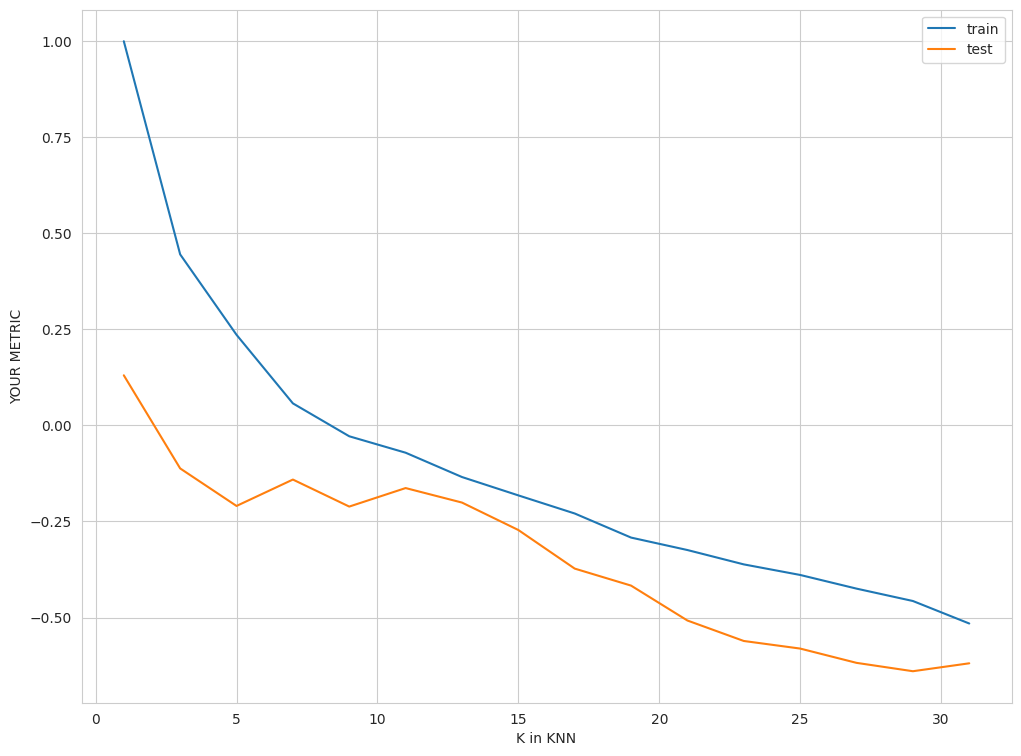

In [76]:
# R-квадрат
params = [i for i in range(1,32, 2)]
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, 
                                          params, r_squared)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

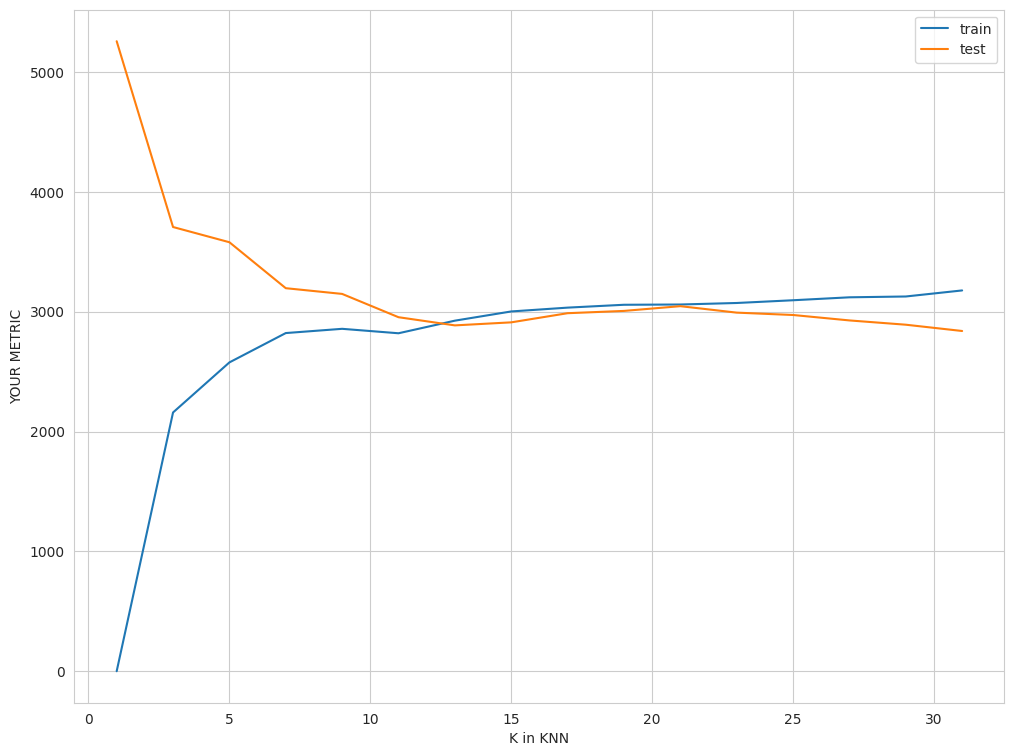

In [77]:
# MSE
params = [i for i in range(1,32, 2)]
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, 
                                          params, mse)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

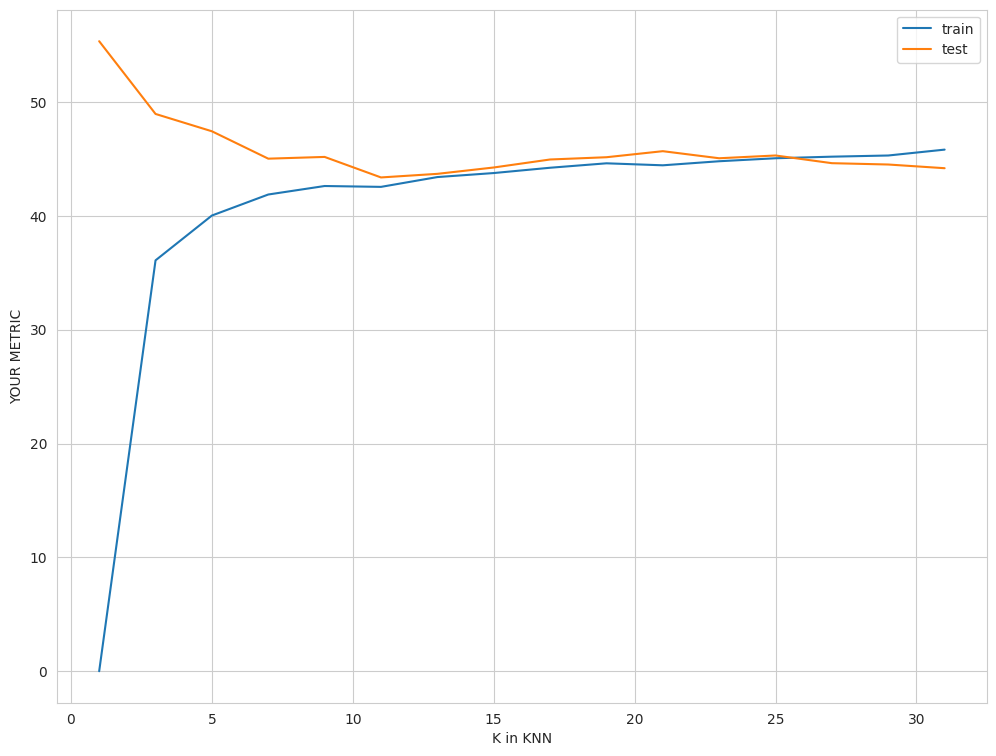

In [78]:
# MAE
params = [i for i in range(1,32, 2)]
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, 
                                          params, mae)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Изберем ```k = 13```.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

Социализация -- чрезвычайно важное явление для познания мира и человеческой сущности. Но как человек с медицинским прошлым (и пока еще настоящим), я не могу не забыть речение, которое приписывают Сократу -- ```Cognosce te ipsum```, что означает ```познай самого себя```. Засим, я решил начинать социализацию с малых доз, постепенно, дабы не ввергнуться в пучину рассеянности.

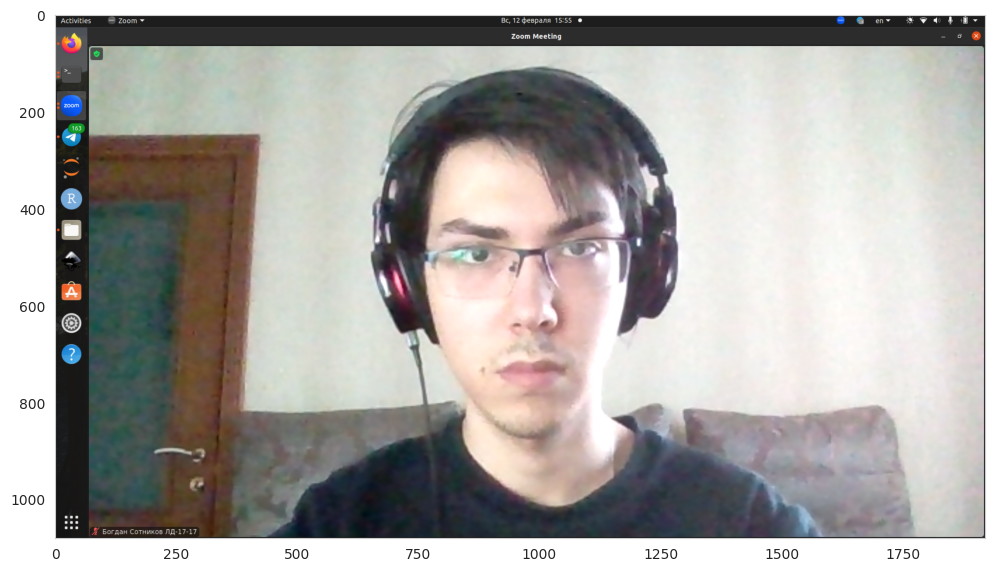

In [79]:
img = plt.imread("/home/asklepiad/Pictures/socialization.png")
_ = plt.imshow(img)
plt.grid(None)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**
 - Интересно -- да.
 
 - Сложно -- да, достаточно сложно, но в рамках разумного.
 
 - Идеи -- пока не совсем представляю, как это реализовать, чтобы и основной материал не пострадал по объему, и эту мысль реализовать, но идея в следующем. Помимо больших проектовых заданий было бы неплохо, как кажется, дать малые тренировочные задания (можно с минимумом баллов или вообще без баллов, чтобы не девальвировать их значение), цель которых -- довести до автоматизма использование некоторых операций, чтобы не раздумывать над каждой строчкой а-ля ```fit или не fit -- вот в чем вопрос...```. Но, возможно, это исключительно моя форма подтормаживания (или особенности "вкатывания" в предмет).

А так все здорово, спасибо.